## Improving Signup Conversion Using ML and A/B Testing

Source: https://github.com/wassupjay/Improving-Signup-Conversion-with-ML-AB-Testing

This project simulates a real-world marketing experiment where machine learning is used to personalize call-to-action (CTA) messages and A/B testing is conducted to validate the effectiveness of the personalization.

Dataset: A synthetic dataset of 10,000 users with the following columns:
- device_type, browser, traffic_source
- scroll_depth, time_on_page
- signed_up (target variable)

🧠 Machine Learning
- Random Forest Classifier predicts probability of user signup.
- One-hot encoding for categorical variables.
- Evaluated using classification metrics and ROC-AUC.

🎯 CTA Personalization
- If the model predicts a probability > 0.5 → “Start Now & Save 30%”
- Else → “Learn More About Us”

🧪 A/B Testing
- Users are randomly split into two groups:
- A (Control): Fixed CTA.
- B (Test): Personalized CTA.
- Signup outcomes are simulated.
- Two-proportion Z-test used to check statistical significance.

📈 Visualization
- Bar chart showing conversion rates for both groups.



In [1]:
# Project: Improving Signup Conversion with ML-based CTA Personalization and A/B Testing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

In [ ]:
# csv_path = 'user_sessions.csv'
csv_path = 'https://raw.githubusercontent.com/wassupjay/Improving-Signup-Conversion-with-ML-AB-Testing/refs/heads/main/user_sessions.csv'
df = pd.read_csv(csv_path)
df

,device_type,browser,traffic_source,scroll_depth,time_on_page,signed_up
0,tablet,firefox,email,94.102708,35.262979,0
1,mobile,safari,paid,56.963010,220.886848,0
2,tablet,safari,organic,50.137193,17.663420,0
3,tablet,edge,email,60.538561,223.977694,0
4,mobile,chrome,social,61.630765,264.532925,0
...,...,...,...,...,...,...
9995,tablet,edge,organic,82.537201,38.412305,0
9996,mobile,safari,organic,18.146722,262.813128,0
9997,desktop,firefox,social,47.641713,162.447947,0
9998,desktop,chrome,organic,94.932549,180.259882,0


In [6]:
df.dropna(subset=['device_type', 'scroll_depth', 'time_on_page', 'signed_up'], inplace=True)
df = pd.get_dummies(df, columns=['device_type', 'browser', 'traffic_source'], drop_first=True)

X = df.drop(columns=['signed_up'])
y = df['signed_up']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1811
           1       0.12      0.01      0.02       189

    accuracy                           0.90      2000
   macro avg       0.52      0.50      0.48      2000
weighted avg       0.83      0.90      0.86      2000

ROC-AUC: 0.5078780760724437


<Axes: title={'center': 'ROC (Receiver Operating Characteristic) Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

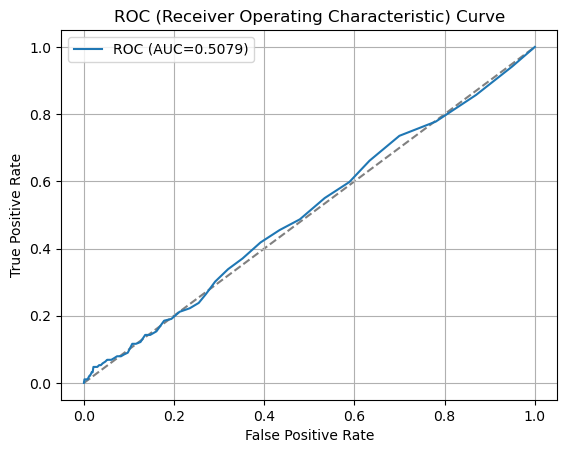

In [9]:
import scikitplot.snsx as sp

sp.aucplot(x=y_test, y=model.predict_proba(X_test)[:, 1])

In [11]:
def get_cta(pred_proba):
    return "Start Now & Save 30%" if pred_proba > 0.5 else "Learn More About Us"

In [12]:
X_new = X_test.copy()
X_new['pred_proba'] = model.predict_proba(X_test)[:, 1]
X_new['cta'] = X_new['pred_proba'].apply(get_cta)
X_new['group'] = np.random.choice(['A', 'B'], size=len(X_new), p=[0.5, 0.5])

In [13]:
X_new['signed_up'] = np.where(
    (X_new['group'] == 'B') & (X_new['pred_proba'] > 0.5), 1,
    np.where((X_new['group'] == 'A'), np.random.binomial(1, 0.085, size=len(X_new)), 0)
)

In [14]:
signup_counts = [X_new[X_new['group'] == 'A']['signed_up'].sum(), X_new[X_new['group'] == 'B']['signed_up'].sum()]
visitor_counts = [X_new[X_new['group'] == 'A'].shape[0], X_new[X_new['group'] == 'B'].shape[0]]

In [21]:
z_stat, p_val = proportions_ztest(signup_counts, visitor_counts)
print(f"Z-statistic: {z_stat:.4f}, P-value: {p_val:.4e}")
if p_val < 0.05:
    print("Result: Statistically significant improvement with personalized CTA.")
else:
    print("Result: No statistically significant difference.")

Z-statistic: 7.9746, P-value: 1.5285e-15
Result: Statistically significant improvement with personalized CTA.


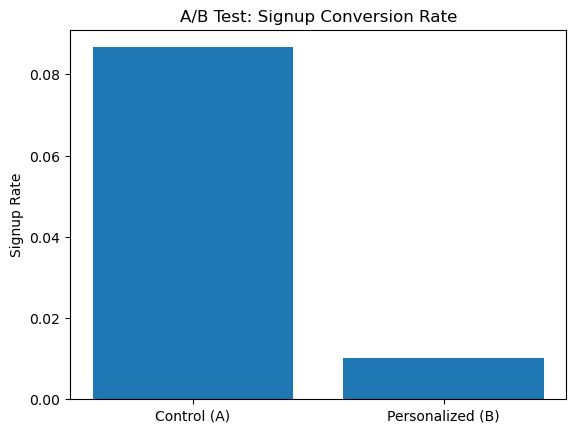

In [16]:
labels = ['Control (A)', 'Personalized (B)']
signup_rates = [signup_counts[0] / visitor_counts[0], signup_counts[1] / visitor_counts[1]]
plt.bar(labels, signup_rates)
plt.ylabel("Signup Rate")
plt.title("A/B Test: Signup Conversion Rate")
plt.show()